# Landmark Classification

Purpose of this notebook: $\newline$
Classify landmarks with CNN's. The [google landmark dataset](https://github.com/cvdfoundation/google-landmark) is used. It contains images of 50 different landmarks. 

In [68]:
## imports

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Subset

from PIL import Image

%matplotlib inline

#### Load the Data

In [35]:
## load the data

# define directories
train_dir = 'landmark_images/train/'
test_dir = 'landmark_images/test/'

# define dataloader parameters
batch_size = 20
num_workers = 1

# split between train and val
val_size = 0.2

# image size
img_size = 128

# define transforms for test and training data
transform_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

transform_train = transforms.Compose([
    transforms.RandomRotation(180),
    transform_test
    ])

# define datasets
test_dataset = datasets.ImageFolder(test_dir, transform_test)
eval_dataset = datasets.ImageFolder(train_dir, transform_test)
train_dataset = datasets.ImageFolder(train_dir, transform_train)

# get indices for dataset split
length = len(train_dataset)
indices = list(range(length))
np.random.shuffle(indices)
split = int(np.floor(val_size * length))
train_idx, eval_idx = indices[split:], indices[:split]

# obtain split datasets
eval_dataset = Subset(eval_dataset, eval_idx)
train_dataset  = Subset(train_dataset, train_idx)

# prepare data loaders
loaders = {}
loaders['test'] = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                num_workers=num_workers, shuffle=True)
loaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                num_workers=num_workers, shuffle=True)
loaders['eval'] = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, 
                                num_workers=num_workers, shuffle=True)

# print info
print('Number of training images: ', len(loaders['train'].dataset)) 
print('Number of validation images: ', len(loaders['eval'].dataset)) 
print('Number of test images: ', len(loaders['test'].dataset))
print('Number of classes: ', len(test_dataset.classes))

Number of training images:  3997
Number of validation images:  999
Number of test images:  1250
Number of classes:  50


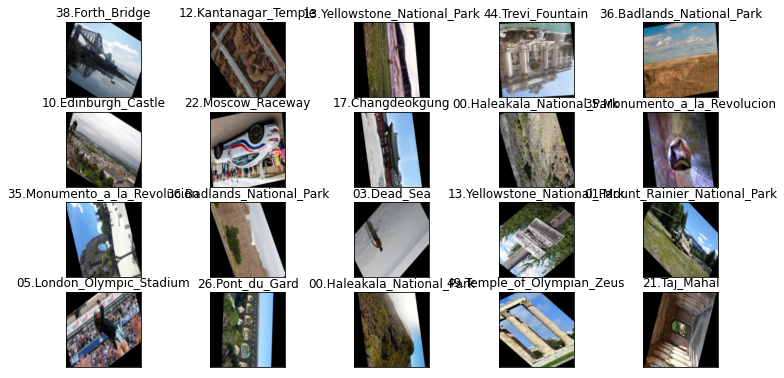

In [36]:
## visualize a batch of data

# get single batch
dataiter = iter(loaders['train'])
images, labels = dataiter.next()

# get list of class
classes = test_dataset.classes

fig = plt.figure(figsize=(2.5*5, 2*4))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    images[idx] = images[idx] / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [37]:
# use cuda if available
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


#### Define the Network

In [59]:
## define architecture
class CustomNet(nn.Module):
    
    def __init__(self): 
        super(CustomNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(256*8*8, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1000, 50)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256*8*8)
        x = self.classifier(x)
    
        return x

model = CustomNet()
if use_cuda:
    model.cuda()

In [60]:
# cross-entropy loss
criterion = nn.CrossEntropyLoss()

# stochastic gradient optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

#### Train the Network

In [62]:
## define the training process

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    eval_loss_min = np.Inf 
    
    # initialize tracker for mean validation loss
    eval_loss_ma = []
    
    # initialize learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        eval_loss = 0.0
        
        # train mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass and backprop
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # update average train loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))

        # eval mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['eval']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass
            output = model(data)
            loss = criterion(output, target)

            # update average validation loss
            eval_loss = eval_loss + ((1 / (batch_idx + 1)) * (loss.item() - eval_loss))

        # adapt learning rate 
        scheduler.step()
            
        # print some statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, eval_loss), '\tLearning rate:', scheduler.get_lr())

        # save the best model
        if eval_loss < eval_loss_min:
            torch.save(model.state_dict(), save_path)
            eval_loss_min = eval_loss
        
        # early stopping if validation loss diverges
        eval_loss_ma.append(eval_loss)
        if epoch > 50 and np.mean(eval_loss_ma[-10:]) > 1.1*eval_loss_min:
            break
        
    return model

In [63]:
## define the weight initialisation

def weight_init(m):
    # get class names
    classname = m.__class__.__name__

    # init with xavier
    if classname.find('Conv') != -1:
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.constant_(m.bias, 0)
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.constant_(m.bias, 0)

In [66]:
## run the training
num_epochs = 100

# init weights
model.apply(weight_init)

# train
model = train(num_epochs, loaders, model, optimizer, criterion, use_cuda, 'model_custom.pt')

Epoch: 1 	Training Loss: 4.471651 	Validation Loss: 4.165487 	Learning rate: [0.1]
Epoch: 2 	Training Loss: 3.916436 	Validation Loss: 3.731844 	Learning rate: [0.1]
Epoch: 3 	Training Loss: 3.585690 	Validation Loss: 3.765624 	Learning rate: [0.1]
Epoch: 4 	Training Loss: 3.411621 	Validation Loss: 3.667217 	Learning rate: [0.1]
Epoch: 5 	Training Loss: 3.222395 	Validation Loss: 3.420242 	Learning rate: [0.1]
Epoch: 6 	Training Loss: 3.095692 	Validation Loss: 3.374677 	Learning rate: [0.1]
Epoch: 7 	Training Loss: 2.975502 	Validation Loss: 3.399135 	Learning rate: [0.1]
Epoch: 8 	Training Loss: 2.869894 	Validation Loss: 3.295708 	Learning rate: [0.1]
Epoch: 9 	Training Loss: 2.767072 	Validation Loss: 3.142353 	Learning rate: [0.1]
Epoch: 10 	Training Loss: 2.665569 	Validation Loss: 3.095667 	Learning rate: [0.025]
Epoch: 11 	Training Loss: 2.446895 	Validation Loss: 2.861077 	Learning rate: [0.05]
Epoch: 12 	Training Loss: 2.353406 	Validation Loss: 2.793334 	Learning rate: [0.0

Epoch: 94 	Training Loss: 1.223705 	Validation Loss: 2.391411 	Learning rate: [0.0001953125]
Epoch: 95 	Training Loss: 1.196445 	Validation Loss: 2.400285 	Learning rate: [0.0001953125]
Epoch: 96 	Training Loss: 1.207686 	Validation Loss: 2.399843 	Learning rate: [0.0001953125]
Epoch: 97 	Training Loss: 1.204541 	Validation Loss: 2.390444 	Learning rate: [0.0001953125]
Epoch: 98 	Training Loss: 1.185041 	Validation Loss: 2.392943 	Learning rate: [0.0001953125]
Epoch: 99 	Training Loss: 1.189811 	Validation Loss: 2.398422 	Learning rate: [0.0001953125]
Epoch: 100 	Training Loss: 1.197610 	Validation Loss: 2.389105 	Learning rate: [4.8828125e-05]


#### Test the Network

In [67]:
## define the test process

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass
        output = model(data)
        loss = criterion(output, target)

        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.item() - test_loss))

        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_custom.pt'))
test(loaders, model, criterion, use_cuda)

Test Loss: 2.252992


Test Accuracy: 46% (577/1250)


#### Prediction

In [74]:
## return the names of the top k landmarks predicted
def predict_landmarks(img_path, k):
    
    img_size = 128
    
    # transforms to resize and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    
    # load the image
    img = Image.open(img_path)
    img = transform(img)
    img = img[None, :]

    # set to eval mode
    model.eval()
    if use_cuda:
        img = img.cuda()
    
    # forward pass and softmax
    output = model(img)
    output = F.softmax(output, dim=-1)
    
    # get output probabilities
    pred = output.topk(k)
    probs = np.array([float(pred[0][0][i]) for i in range(k)])
    places = np.array([test_dataset.classes[pred[1][0][i]].split('.')[1] for i in range(k)])
    
    return probs, places

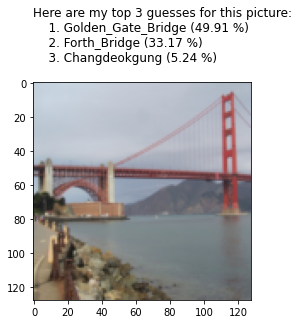

In [76]:
def suggest_locations(img_path):
    # get landmark predictions
    pred = predict_landmarks(img_path, 3)
    
    # transforms to resize and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
        ])
    
    # load the image
    img = Image.open(img_path)
    img = transform(img)
    
    fig = plt.figure(figsize=(5, 4))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    msg = 'Here are my top 3 guesses for this picture:\n' \
        + '    1. %s (%.2f %%)\n' % (pred[1][0], pred[0][0]*100) \
        + '    2. %s (%.2f %%)\n' % (pred[1][1], pred[0][1]*100) \
        + '    3. %s (%.2f %%)\n' % (pred[1][2], pred[0][2]*100)
    plt.title(msg, loc='left')
    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')